In [1]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import csv
import copy
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime
from collections import deque
from sklearn.tree import DecisionTreeClassifier


In [148]:
# Experiment settings
'./DATA/logs/synthetic_log_bc1.csv'
dataset_label = 'synthetic_log_bc1'

performance_measure_type = 'ROCAUC'

dataset_loc = './DATA/logs/'+ dataset_label +'.csv'
try:
    os.makedirs('./result/%s'%(dataset_label))
except:
    pass

# Set streaming classifier
classifier = 'hatc'
if classifier == 'htc':
    streaming_classifier = tree.HoeffdingTreeClassifier(grace_period=10, split_criterion='info_gain')
elif classifier =='hatc':
    streaming_classifier = tree.HoeffdingAdaptiveTreeClassifier(grace_period=100, split_criterion='hellinger' )
elif classifier == 'efdt':
    streaming_classifier = tree.ExtremelyFastDecisionTreeClassifier(grace_period=100,split_criterion='info_gain')

In [149]:
# Invoke parameters for dataset
window_size = 100
test_size = 30
with open('./dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefix = parameters['maximum_prefix']
    maximum_prefix =12

{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity'], 'maximum_prefix': 12}


In [150]:
dataset = stream.iter_csv(
            dataset_loc
            )

totallength = len(list(dataset))

In [151]:
dataset = stream.iter_csv(
            dataset_loc,
            # drop=['Complete Timestamp'],
            target='outcome'
            )
enctype = 'Index-base'

In [152]:
streaming_db ={}
training_models ={}
test_cases = deque()
feature_matrix ={}

save_model = {}
casecount = 0
rowcounter = 0
finished_db ={}
running_case = 0
window_acc_dict = {}
prediction_result = dict()
for i in range(1, maximum_prefix+1): prediction_result[i] = {}
finished_caseid = set()
usedingrace = set()

In [153]:
def performance_measurement(metrics, type='Accuracy'):
    if type == 'Accuracy':
        return_value = metrics.Accuracy()
    elif type =='F1':
        return_value = metrics.F1()
    elif type =='ROCAUC':
        return_value = metrics.ROCAUC()
    elif type == 'WeightedF1':
        return_value = metrics.WeightedF1()
        
    return return_value

In [154]:
def display_progress(row_counting, total_length, interval=500):
    if rowcounter%interval == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running cases: %s'%(len(streaming_db)))

In [155]:
def update_test_cases(new_case, test_cases):
    test_cases.append(new_case)
    if len(test_cases) > test_size:
        test_cases.popleft()

In [156]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''
for x,y in dataset:
    display_progress(rowcounter, totallength)
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
    
    if dataset_label !='bpic15':
        x['ts'] = x['ts'][:-4]

    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)
    case_bin.set_enctype(enctype)

    if caseid not in list(streaming_db.keys()):
        case_bin.set_prefix_length(1)    
        streaming_db[caseid] = []
    elif caseid in finished_caseid:
        pass
    else:
        case_bin.set_prefix_length(len(streaming_db[caseid])+1)
        case_bin.set_prev_enc(streaming_db[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded(catattrs=catatars,enctype=enctype)
    ts = case_bin.event['ts']
    streaming_db[caseid].append(case_bin)
    # Detect label appeared case 
    if outcome != '' and caseid not in finished_caseid:
        usedingrace.add(caseid)
        for i in streaming_db[caseid]:
            i.update_truelabel(outcome)
        finished_caseid.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount < 200:
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(maximum_prefix)]=set()
                    training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier,
                                                               0]
                feature_list = list(streaming_db[caseid][maximum_prefix-1].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(maximum_prefix)].add(x) 
            
        else:
            break

0.0 % Case finished: 0 Running cases: 0
4.65 % Case finished: 41 Running cases: 49
9.3 % Case finished: 86 Running cases: 95
13.95 % Case finished: 138 Running cases: 145
18.59 % Case finished: 185 Running cases: 193


In [157]:
casecount_=0
for caseid in list(usedingrace):

    case_length = len(streaming_db[caseid])
    if case_length >= maximum_prefix:
        x = streaming_db[caseid][maximum_prefix-1]
        x.encoded = utils.readjustment_training(x.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
        outcome = x.true_label
        training_models['prefix_%s'%(x.prefix_length)][0].learn_one(x.encoded,outcome)
        training_models['prefix_%s'%(x.prefix_length)][1] +=1
        
        update_test_cases(streaming_db[caseid], test_cases)
    
    prediction_result[maximum_prefix][casecount_] = {}
    y_truelist = []
    y_predlist = []
    for case in test_cases:
        if len(case) >= maximum_prefix:
            x = case[maximum_prefix-1]
            model = training_models['prefix_%s'%(x.prefix_length)][0]
            y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba_one(x.encoded)
            y_truelist.append(x.true_label)
            y_predlist.append(y_pred)
    prediction_result[maximum_prefix][casecount_]['y_true'] = y_truelist
    prediction_result[maximum_prefix][casecount_]['y_pred'] = y_predlist
    casecount_ +=1

In [159]:
'''
Streaming event label prediction start.
- Test and training steps are executed when case finished/ event arrived with label
'''
for i in streaming_db.keys(): usedingrace.add(i)
streaming_db ={}
cdhappend ={}
for i in range(1, maximum_prefix+1): cdhappend[i] = 0
for x,y in dataset:
    display_progress(rowcounter, totallength)
        
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)

    if dataset_label !='bpic15':
        x['ts'] = x['ts'][:-4]

    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
    x.pop('caseid')
    x.pop('outcome')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
            running_case +=1
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        
        if case_bin.prefix_length == maximum_prefix:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
        streaming_db[caseid].append(case_bin)

        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            finished_caseid.add(caseid)
            
            # Adding newly finished case to training set.
            casecount +=1    

            # Modify encoded attributes of cases with feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:

                update_test_cases(streaming_db[caseid], test_cases)
                streaming_db[caseid][maximum_prefix-1].update_truelabel(outcome)
                x = streaming_db[caseid][maximum_prefix-1].encoded
                prefix_length =streaming_db[caseid][maximum_prefix-1].prefix_length
                training_models['prefix_%s'%(prefix_length)][0].learn_one(x, outcome)
                training_models['prefix_%s'%(prefix_length)][1] +=1

                y_pred = training_models['prefix_%s'%(prefix_length)][0].predict_one(x)
                model_update_count = training_models['prefix_%s'%(prefix_length)][1]
                save_model['%s_%s'%(prefix_length, model_update_count)] = training_models['prefix_%s'%(streaming_db[caseid][maximum_prefix-1].prefix_length)][0]

            y_truelist = []
            y_predlist = []

            for case in test_cases:
                if len(case) >= maximum_prefix:
                    x = case[maximum_prefix-1]
                    length = x.prefix_length
                    y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba_one(x.encoded)
                    y_truelist.append(x.true_label)
                    y_predlist.append(y_pred)

            prediction_result[maximum_prefix][casecount] = {}
            prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
            prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist
            if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                cdhappend[maximum_prefix] = model_update_count


23.24 % Case finished: 225 Running cases: 32
27.89 % Case finished: 273 Running cases: 83
32.54 % Case finished: 323 Running cases: 131
37.19 % Case finished: 375 Running cases: 181
41.84 % Case finished: 420 Running cases: 230
46.49 % Case finished: 466 Running cases: 275
51.13 % Case finished: 512 Running cases: 322
55.78 % Case finished: 562 Running cases: 368
60.43 % Case finished: 608 Running cases: 413
65.08 % Case finished: 648 Running cases: 459
69.73 % Case finished: 692 Running cases: 500
74.38 % Case finished: 739 Running cases: 548
79.03 % Case finished: 785 Running cases: 592
83.67 % Case finished: 830 Running cases: 638
88.32 % Case finished: 873 Running cases: 682
92.97 % Case finished: 917 Running cases: 727
97.62 % Case finished: 967 Running cases: 776


In [160]:
len(streaming_db.keys())

793

In [115]:
prediction_result[12][100]

{'y_true': [], 'y_pred': []}

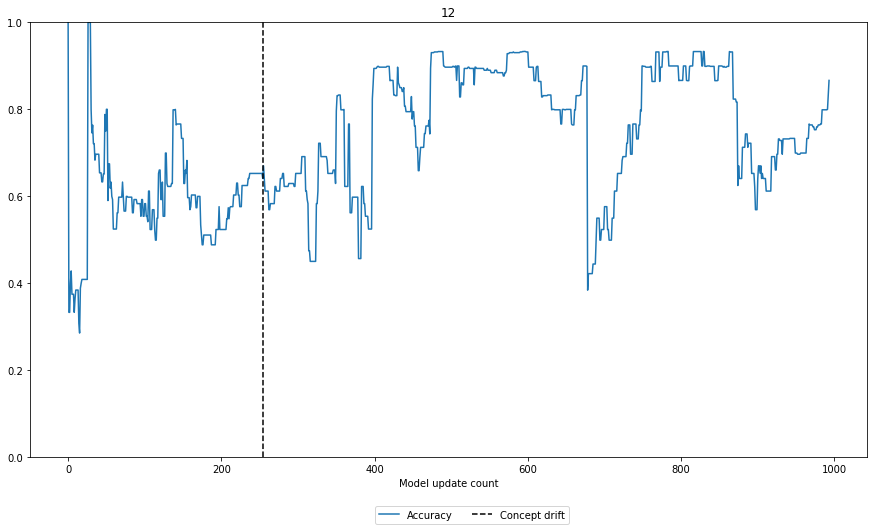

<Figure size 432x288 with 0 Axes>

In [161]:
evaluation_method = 'F1'
prefix = maximum_prefix
update_count =[]
evaluation_list = []
length_list = []
for update in prediction_result[prefix].keys():
    y_true = prediction_result[prefix][update]['y_true']
    y_pred_prob = prediction_result[prefix][update]['y_pred']
    y_pred = [max(x, key=x.get) for x in y_pred_prob]
    update_count.append(update)

    if evaluation_method =='Accuracy':
        value = accuracy_score(y_true, y_pred)
    elif evaluation_method =='F1':
        value = f1_score(y_true, y_pred, average='macro')
#             warnings.filterwarnings("ignore")

    elif evaluation_method =='ROCAUC':
        y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])
        try:
            value = roc_auc_score(y_true, y_pred_prob[:, 1])
        except:
            value = 0
    evaluation_list.append(value)
plt.figure(figsize=(15,8))
plt.plot(update_count, evaluation_list, label = 'Accuracy')
#     plt.plot(update_count, length_list)
plt.axvline(cdhappend[prefix], color = 'black', linestyle ='--', label = 'Concept drift')
plt.title(prefix)
plt.xlabel('Model update count')
plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
plt.ylim(0,1)
plt.show()
# plt.savefig('./img/prefix_%s_%s update.png'%(prefix, evaluation_method), dpi=250)
plt.cla()
plt.clf()

In [99]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X, y = load_breast_cancer(return_X_y=True)
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
roc_auc_score(y, clf.predict_proba(X)[:, 1])
roc_auc_score(y, clf.decision_function(X))

0.9946355900850907

In [47]:
Y_pred = []
for x in y_pred_prob:
    Y_pred.append([x['False'], x['True']])
y_pred_prob = np.array([[x['False'], x['True']] for x in y_pred_prob])

In [42]:
roc_auc_score(y_true, np.array(Y_pred)[:, 1])

0.6282612661923006

In [41]:
np.array(Y_pred)[:, 1].shape

(300,)

In [35]:
np.array(y_true).shape

(300,)

In [36]:
y.shape

(569,)

In [38]:
clf.predict_proba(X)[:,1].shape

(569,)